In [1]:
import csv
import cv2
import numpy as np
import os
import json
import matplotlib.pyplot as plt

## 获取图像的颜色直方图特征，可以修改bins，带椭圆蒙版
## 可指定RGB和HSV色彩空间

In [2]:
# 如何获取颜色特征
class ColorDescriptor:
    def __init__(self, bins):
        # 存储 3D 直方图的数量
        self.bins = bins

    def describe(self, image):
        # 将图像转换为 HSV 色彩空间并初始化
        # HSV 色彩空间：H 0-179，S 0-255，V 0-255
        # BGR: 0-255
        # 用于量化图像的特征
        image = cv2.cvtColor(image, cv2.IMREAD_COLOR)  # OpenCV读取颜色顺序：BRG
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        # print("image", image)
        features = []
        # 获取尺寸并计算图像的中心
        (h, w) = image.shape[:2] # height, width
        (cX, cY) = (int(w * 0.5), int(h * 0.5)) # half of height, half of width
        # print("cx, cy", (cX, cY))
        # 将图像分成四份 rectangles/segments (top-left,top-right, bottom-right, bottom-left)
        segments = [(0, cX, 0, cY), (cX, w, 0, cY), (cX, w, cY, h), (0, cX, cY, h)]
        # 构建代表图像中心的椭圆蒙版
        (axesX, axesY) = (int(w * 0.75) // 2, int(h * 0.75) // 2)  # 椭圆轴心
        ellipMask = np.zeros(image.shape[:2], dtype="uint8") # 先构造整张图片的向量
        cv2.ellipse(ellipMask, (cX, cY), (axesX, axesY), 0, 0, 360, 255, -1) # 中心椭圆蒙版
        # loop over the segments
        for (startX, endX, startY, endY) in segments:  # 图像的四份
            # 为图像的每个角构建一个掩码，从中减去椭圆中心
            cornerMask = np.zeros(image.shape[:2], dtype="uint8")
            cv2.rectangle(cornerMask, (startX, startY), (endX, endY), 255, -1) # 四份各自的蒙版
            cv2.ellipse(ellipMask, (cX, cY), (axesX, axesY), 0, 0, 360, 255, -1)
            # 从图像中提取颜色直方图，然后更新特征向量
            hist = self.histogram(image, cornerMask)
            features.extend(hist)
        # 从椭圆区域提取颜色直方图并更新特征向量
        # 共有五份特征向量，四个角 + 椭圆
        hist = self.histogram(image, ellipMask)
        features.extend(hist)
        # 返回特征向量
        return features

    def histogram(self, image, mask):
        # 使用提供的每个通道的 bin 数量，从图像的遮罩区域中提取 3D 颜色直方图
        # bins = [8, 12, 3], 第二个参数是计算的通道数，mask掩码
        # bins 是对三个颜色的分割，实现降维；例如[16,16,16] 最终分割 256 / 16 = 16. 16 * 16 * 16 = 4096 种像素index
        # bins 实现降维 self.bins

        # hist = cv2.calcHist([image], [0, 1, 2], mask, self.bins, [0, 180, 0, 256, 0, 256]) # HSV
        hist = cv2.calcHist([image], [0, 1, 2], mask, (16, 16, 16), [0, 256, 0, 256, 0, 256])  # BGR
        hist = cv2.normalize(hist, hist).flatten() # 归一化
        return hist
        # 返回直方图


def get_sift_features(pic_path):
    numWords = 64
    sift_detector = cv2.SIFT_create()
    des_list =[]
    pic_list = os.listdir(pic_path)
    for pic in pic_list:
        path = pic_path + pic
        img = cv2.imread(path)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        kp, des = sift_detector.detectAndCompute(gray, None)  #
        des_list.append(des)

## 构造图像特征库

In [3]:
def get_feature(img_file, bins):
    cd = ColorDescriptor(bins)
    test_img_ = cv2.imread(img_file)
    test_img_features = np.array(cd.describe(test_img_))
    return test_img_features


def pic_library(piclib, pic_path):
    pic_list = os.listdir(pic_path)
    lib = open(piclib, "w")
    for pic in pic_list:
        path_p = pic_path + pic
        tmp_features = list(get_feature(path_p, bins))
        features = [str(f) for f in tmp_features]
        lib.write("%s,%s\n" % (path_p, ",".join(features)))
    lib.close()


## 计算特征相似度 提供两种方式，卡方距离和巴氏距离

In [4]:

def distance(histA, histB, eps = 1e-10):
    # 计算卡方距离， 越小表示越相似
    d = 0.5 * np.sum([((a - b) ** 2) / (a + b + eps)
        for (a, b) in zip(histA, histB)])
    # 返回卡方距离
    return d

def BhattachAraay(histA, histB):
    # 计算巴氏距离 ，范围在0 - 1 之间，越小表示越相似
    match = cv2.compareHist(histA, histB, cv2.HISTCMP_BHATTACHARYYA)
    return match


## 查询图片，可先构建特征库再查询，亦可直接遍历所有图片查询

In [19]:
def query_pic(lib, query_image):
    query_img_features = get_feature(query_image, bins)
    f = open(lib, "r", encoding="utf-8")
    reader = csv.reader(f)
    dis_dic = {}
    for pic in reader:
        tmp_features = [float(x) for x in pic[1:]]  # pic[0] 是 图像文件名
        d = distance(tmp_features, query_img_features)
        dis_dic[pic[0]] = d
    result = sorted([(v, k) for (k, v) in dis_dic.items()])
    print(result)
    return result


def query_direct(allpic, image):
    query_img_features = get_feature(image, bins)
    pic_p = os.listdir(allpic)
    pic_dic = {}
    for item in pic_p:
        path_tmp = allpic + item
        tmp_features = get_feature(path_tmp, bins)
        d = BhattachAraay(tmp_features, query_img_features)
        # print(path_tmp, d)
        pic_dic[path_tmp] = d
    result = sorted([(v,k) for (k,v) in pic_dic.items()])
    print(result)
    return result

## 展示查询结果 

In [8]:
def queryresult(resultlist, rank, test_img):
    res = []
    for i in range(rank):
        res.append(resultlist[i][1])
        
    plt.figure(figsize=(15,15))
    
    plt.subplot(2,2,1), plt.title('Query Image')
    tmp1 = cv2.imread(test_img)
    plt.imshow(tmp1[:,:,[2,1,0]]),plt.axis('off')
    
    i = 1
    
    for item in res:
        i += 1
        plt.subplot(2,2,i), plt.title('Query Rank' + str(i-1) + item)
        tmp = cv2.imread(item,-1)
        plt.imshow(tmp[:,:,[2,1,0]]),plt.axis('off')
        
    plt.show()
    

## 构建所有图像的特征库

In [7]:
features_lib = "all_features.csv" # 特征库文件
all_pictures_dir = "./pic_library/" # 所有图像文件
# bins = (8, 12, 3)  # HSV bins
bins = (16,16,16)  # 指定 划分 BGR bins 
pic_library(features_lib, all_pictures_dir)

## 查询

In [24]:
test_img = "./snowmountain_test.png"  # 待查询图像

result1 = query_pic(features_lib, test_img)  # 第一个参数 特征库文件，第二个参数 待查询图片
result2 = query_direct(all_pictures_dir, test_img) # 第一个参数 所有图像的目录，第二个参数 待查询图片

[(14.491062317365945, './pic_library/snowmountain_03.png'), (17.239117714364927, './pic_library/snowmountain_02.png'), (18.62086904451501, './pic_library/citynight_02.png'), (20.24601063313003, './pic_library/beach_02.png'), (21.667859000632298, './pic_library/snowmountain_01.png'), (22.705865939357587, './pic_library/beach_01.png'), (23.740588244833198, './pic_library/citynight_03.png'), (24.06412932989194, './pic_library/citynight_01.png'), (24.95117203098037, './pic_library/forest_02.png'), (27.413753702935885, './pic_library/beach_03.png'), (33.401250916881125, './pic_library/forest_03.png'), (38.491458118794384, './pic_library/forest_01.png')]
[(0.6499641167941907, './pic_library/snowmountain_03.png'), (0.688479963254106, './pic_library/snowmountain_02.png'), (0.8137352044866379, './pic_library/beach_02.png'), (0.8594494746158272, './pic_library/beach_01.png'), (0.8712849903435506, './pic_library/citynight_03.png'), (0.8881931152435134, './pic_library/beach_03.png'), (0.8965389522

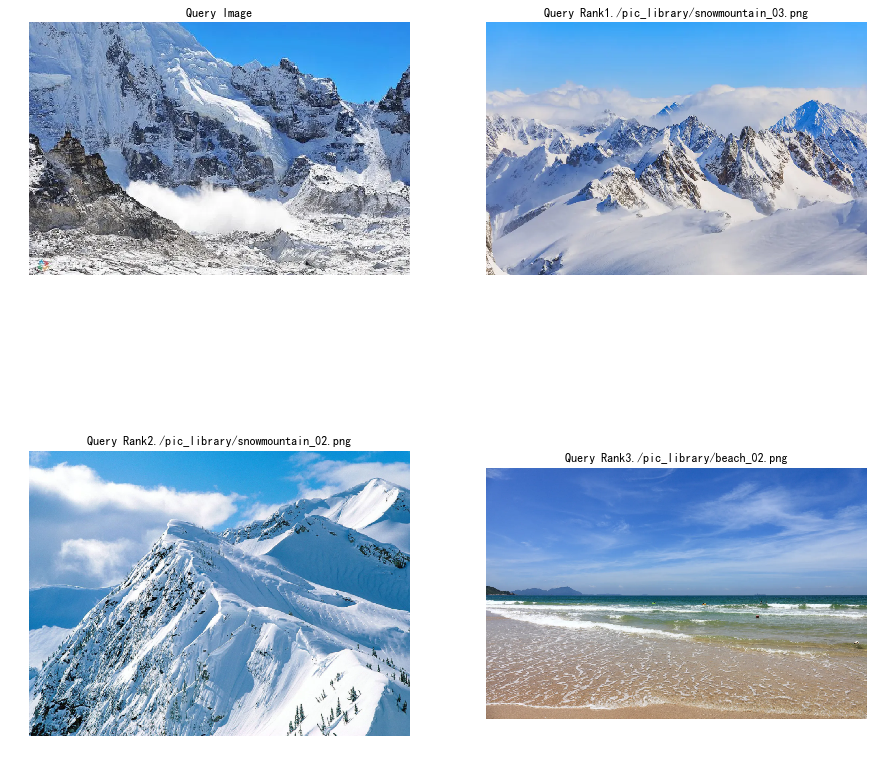

In [25]:
rank = 3  # 最相似的前3张
queryresult(result2, rank, test_img)